In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayyanarkadalkani/paddy-seeds-quality-classification-dataset")

print("Path to dataset files:", path)

C:\Users\abbus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 183M/183M [01:04<00:00, 2.95MB/s] 

Extracting files...


Path to dataset files: C:\Users\abbus\.cache\kagglehub\datasets\ayyanarkadalkani\paddy-seeds-quality-classification-dataset\versions\1


# Task
Classify paddy seeds as "pure" or "impure" using the dataset located at `/root/.cache/kagglehub/datasets/ayyanarkadalkani/paddy-seeds-quality-classification-dataset/versions/1`, aiming for an accuracy of 99%.

## Load and Inspect Dataset

### Subtask:
Load the dataset from the provided path and inspect its structure, including the types of features and the target variable (pure/impure). This step will help us understand if the data is tabular, image-based, or another format.


**Reasoning**:
The first instruction is to list the contents of the provided path to identify the data files and their format. I will use `os.listdir` to achieve this.



In [2]:
import os

# List the contents of the downloaded dataset directory
print(os.listdir(path))

['Paddy Seeds Classification Dataset']


**Reasoning**:
The previous output showed that the downloaded dataset is within a subfolder named 'Paddy Seeds Classification Dataset'. I need to explore the contents of this subfolder to identify the actual data files and determine if they are tabular or image-based, as per the subtask's instruction to inspect the dataset structure.



In [3]:
import os

dataset_subfolder_path = os.path.join(path, 'Paddy Seeds Classification Dataset')
print(os.listdir(dataset_subfolder_path))

['train', 'test', 'validation']


**Reasoning**:
The previous output showed 'train', 'test', and 'validation' subfolders. To further inspect the dataset structure and confirm if it's an image-based dataset, I need to list the contents of one of these subfolders, specifically the 'train' directory.



In [4]:
import os

train_path = os.path.join(dataset_subfolder_path, 'train')
print(os.listdir(train_path))

['pure', 'impure']


**Reasoning**:
The previous output showed 'pure' and 'impure' subfolders within the 'train' directory, strongly suggesting an image-based dataset with these as class labels. To confirm this and inspect the actual data files, I will list the contents of the 'pure' subfolder to see if it contains image files.



In [5]:
import os

pure_class_path = os.path.join(train_path, 'pure')
print(os.listdir(pure_class_path)[:5]) # Print first 5 files to avoid long output
print(f"Total files in 'pure' class: {len(os.listdir(pure_class_path))}")

['20200531_161748.jpg', '20200531_154930.jpg', '20200531_155431.jpg', '20200601_125937.jpg', '20200531_160523.jpg']
Total files in 'pure' class: 567


**Reasoning**:
The previous steps have confirmed that the dataset is image-based, with 'train', 'test', and 'validation' directories, each containing 'pure' and 'impure' subfolders for classification. Now, I need to load these images into a format suitable for machine learning. I will use `tensorflow.keras.preprocessing.image.ImageDataGenerator` to load the images, which will also handle resizing and batching.



In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub

# Re-download the dataset to ensure it's available in the current environment
path = kagglehub.dataset_download("ayyanarkadalkani/paddy-seeds-quality-classification-dataset")
print("Path to dataset files (after re-download):", path)

# Define dataset subfolder path based on the fresh download
dataset_subfolder_path = os.path.join(path, 'Paddy Seeds Classification Dataset')

# Define image dimensions and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Create an ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for validation and test (only rescaling)
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_subfolder_path, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load validation data
validation_generator = validation_test_datagen.flow_from_directory(
    os.path.join(dataset_subfolder_path, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load test data
test_generator = validation_test_datagen.flow_from_directory(
    os.path.join(dataset_subfolder_path, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Keep data in order for evaluation
)

print("Image data generators created successfully.")
print(f"Training classes: {train_generator.class_indices}")
print(f"Validation classes: {validation_generator.class_indices}")
print(f"Test classes: {test_generator.class_indices}")

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # 'sigmoid' for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_paddy_seed_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
EPOCHS = 20 # You can adjust this number
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training complete.")

100%|██████████| 183M/183M [00:00<00:00, 241MB/s]

Extracting files...


Path to dataset files (after re-download): /root/.cache/kagglehub/datasets/ayyanarkadalkani/paddy-seeds-quality-classification-dataset/versions/1
Found 1214 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Image data generators created successfully.
Training classes: {'impure': 0, 'pure': 1}
Validation classes: {'impure': 0, 'pure': 1}
Test classes: {'impure': 0, 'pure': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.5551 - loss: 0.8667 - val_accuracy: 0.6356 - val_loss: 0.5957
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.8576 - loss: 0.3631 - val_accuracy: 0.7881 - val_loss: 0.5003
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.9031 - loss: 0.2734 - val_accuracy: 0.7712 - val_loss: 0.6670
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.8947 - loss: 0.3043 - val_accuracy: 0.6780 - val_loss: 1.0647
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9288 - loss: 0.2221 - val_accuracy: 0.6949 - val_loss: 1.0396
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.9547 - loss: 0.1691 - val_accuracy: 0.7288 - val_loss: 1.0509
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.9577 - loss: 0.1603 - val_accuracy: 0.7542 - val_loss: 0.9525
Model training complete.


**Reasoning**:
The model has been successfully trained in the previous step, so I will now evaluate its performance on the test dataset using the `evaluate` method and print the resulting loss and accuracy to assess its generalization capabilities.



In [10]:
print("Evaluating model on test data...")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on test data...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.8044 - loss: 0.4572
Test Loss: 0.4672
Test Accuracy: 0.7792


**Reasoning**:
The current model achieved a test accuracy of 77.92%, which is below the target of 99%. To significantly improve the model's performance and potentially reach the target, I will implement transfer learning using a pre-trained convolutional neural network. This typically involves using a pre-trained model as a feature extractor and adding a custom classification head.



In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base
model_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # 'sigmoid' for binary classification
])

# Compile the new model
model_transfer.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_transfer.summary()

# Define callbacks for training
early_stopping_transfer = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_transfer = ModelCheckpoint('best_paddy_seed_model_transfer.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
EPOCHS_TRANSFER = 10 # Start with fewer epochs for transfer learning
history_transfer = model_transfer.fit(
    train_generator,
    epochs=EPOCHS_TRANSFER,
    validation_data=validation_generator,
    callbacks=[early_stopping_transfer, model_checkpoint_transfer]
)

print("Transfer learning model training complete.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,744,769 (48.62 MB)

 Trainable params: 10,486,785 (40.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 925ms/step - accuracy: 0.7120 - loss: 3.3946 - val_accuracy: 0.9322 - val_loss: 0.1701
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.9482 - loss: 0.1984 - val_accuracy: 0.9746 - val_loss: 0.0566
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9596 - loss: 0.1277 - val_accuracy: 0.9915 - val_loss: 0.0512
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.9564 - loss: 0.1375 - val_accuracy: 1.0000 - val_loss: 0.0621
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9732 - loss: 0.0742 - val_accuracy: 1.0000 - val_loss: 0.0567
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9550 - loss: 0.1138 - val_accuracy: 0.9407 - val_loss: 0.0919
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9571 - loss: 0.1043 - val_accuracy: 0.9915 - val_loss: 0.0441
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9730 - loss: 0.0734 - val_accuracy

**Reasoning**:
The transfer learning model has been trained. Now, I will evaluate its performance on the test dataset to get the final accuracy and loss metrics, which is a necessary step to compare against the target accuracy.



In [12]:
print("Evaluating transfer learning model on test data...")
loss_transfer, accuracy_transfer = model_transfer.evaluate(test_generator)
print(f"Test Loss (Transfer Learning): {loss_transfer:.4f}")
print(f"Test Accuracy (Transfer Learning): {accuracy_transfer:.4f}")

Evaluating transfer learning model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9721 - loss: 0.1032
Test Loss (Transfer Learning): 0.1358
Test Accuracy (Transfer Learning): 0.9567


## Train Classification Model (Retry with Fine-tuning)

### Subtask:
Further improve the model's performance by fine-tuning the pre-trained MobileNetV2 model.


**Reasoning**:
The current model's accuracy is 95.67%, which is close but not yet at the target of 99%. To further improve performance, I will follow the instructions to fine-tune the pre-trained MobileNetV2 base by unfreezing its top layers and retraining the entire model with a very low learning rate, then continue training for more epochs.



In [13]:
import tensorflow as tf

# Unfreeze the base model layers
base_model.trainable = True

# It's important to recompile your model after you make changes to the `trainable` attribute
# A very low learning rate is crucial for fine-tuning to prevent large weight updates
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Use a very low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# Continue training the model with fine-tuning
EPOCHS_FINE_TUNE = 10 # You can adjust this number
history_fine_tune = model_transfer.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=[early_stopping_transfer, model_checkpoint_transfer] # Reuse the same callbacks
)

print("Fine-tuning of transfer learning model complete.")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,744,769 (48.62 MB)

 Trainable params: 12,710,657 (48.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8169 - loss: 0.7378 - val_accuracy: 0.9831 - val_loss: 0.0327
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9101 - loss: 0.2889 - val_accuracy: 0.9746 - val_loss: 0.0589
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9332 - loss: 0.1940 - val_accuracy: 0.9576 - val_loss: 0.1079
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9521 - loss: 0.1729 - val_accuracy: 0.9153 - val_loss: 0.1907
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9575 - loss: 0.1516 - val_accuracy: 0.8983 - val_loss: 0.2875
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9586 - loss: 0.1200 - val_accuracy: 0.8644 - val_loss: 0.3437
Fine-tuning of transfer learning model complete.


**Reasoning**:
The model has been fine-tuned in the previous step, so I will now evaluate its performance on the test dataset to assess if the fine-tuning achieved the desired improvement and to compare it against the target accuracy of 99%.



In [14]:
print("Evaluating fine-tuned transfer learning model on test data...")
loss_fine_tune, accuracy_fine_tune = model_transfer.evaluate(test_generator)
print(f"Test Loss (Fine-tuned Transfer Learning): {loss_fine_tune:.4f}")
print(f"Test Accuracy (Fine-tuned Transfer Learning): {accuracy_fine_tune:.4f}")

Evaluating fine-tuned transfer learning model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.9701 - loss: 0.0837
Test Loss (Fine-tuned Transfer Learning): 0.0976
Test Accuracy (Fine-tuned Transfer Learning): 0.9654


**Reasoning**:
The fine-tuned model achieved an accuracy of 96.54%, which is an improvement but still short of the 99% target. A common strategy to further enhance transfer learning models while preventing overfitting is to unfreeze only a few of the top layers of the pre-trained base model instead of the entire base. This allows the model to adapt its deeper feature extraction layers to the specific dataset without losing too much of the general features learned from ImageNet. I will unfreeze the last few convolutional blocks of the MobileNetV2 base model and re-train with a very low learning rate for more epochs.

**Reasoning**:
Following the strategy to unfreeze only the top layers for fine-tuning, I will first identify the layers of the MobileNetV2 base model. Then, I will unfreeze the last few convolutional blocks while keeping the earlier layers frozen, recompile the model with a very low learning rate, and continue training to further improve accuracy.



In [15]:
import tensorflow as tf

# Unfreeze all layers of the base model first
base_model.trainable = True

# Freeze all layers first, then unfreeze the last few blocks
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few convolutional blocks (e.g., last 20 layers for MobileNetV2)
# The exact number might need experimentation based on model architecture
# MobileNetV2 has around 155-156 layers, so unfreezing ~20 layers would be the last couple of blocks.
fine_tune_at = 120 # This number is an estimate, adjust based on experimentation

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile the model with a very low learning rate for fine-tuning
# It's crucial to recompile after changing `trainable` attributes
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), # Even lower learning rate for fine-tuning base model layers
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# Continue training the model with fine-tuning on top layers
# Using the same callbacks for early stopping and model checkpointing
EPOCHS_FINE_TUNE_TOP = 15 # More epochs for fine-tuning, adjust as needed
history_fine_tune_top = model_transfer.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE_TOP,
    validation_data=validation_generator,
    callbacks=[early_stopping_transfer, model_checkpoint_transfer]
)

print("Fine-tuning of top layers of transfer learning model complete.")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,744,769 (48.62 MB)

 Trainable params: 12,111,681 (46.20 MB)

 Non-trainable params: 633,088 (2.42 MB)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 647ms/step - accuracy: 0.9230 - loss: 0.3019 - val_accuracy: 0.9831 - val_loss: 0.0314
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.9306 - loss: 0.2574 - val_accuracy: 0.9831 - val_loss: 0.0300
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9259 - loss: 0.2409 - val_accuracy: 0.9831 - val_loss: 0.0293
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9383 - loss: 0.2072 - val_accuracy: 0.9831 - val_loss: 0.0286
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9349 - loss: 0.2488 - val_accuracy: 0.9831 - val_loss: 0.0274
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.9302 - loss: 0.2281 - val_accuracy: 0.9915 - val_loss: 0.0266
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.9508 - loss: 0.1334 - val_accuracy: 0.9915 - val_loss: 0.0265
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.9442 - loss: 0.1754 - val_accuracy:

**Reasoning**:
The model has been fine-tuned further by unfreezing its top layers. Now, I need to evaluate its performance on the test dataset to verify if this additional fine-tuning step has improved the accuracy and to compare it against the target accuracy of 99%.



In [16]:
print("Evaluating fine-tuned transfer learning model on test data...")
loss_fine_tune_top, accuracy_fine_tune_top = model_transfer.evaluate(test_generator)
print(f"Test Loss (Fine-tuned Top Layers): {loss_fine_tune_top:.4f}")
print(f"Test Accuracy (Fine-tuned Top Layers): {accuracy_fine_tune_top:.4f}")

Evaluating fine-tuned transfer learning model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - accuracy: 0.9692 - loss: 0.0710
Test Loss (Fine-tuned Top Layers): 0.0969
Test Accuracy (Fine-tuned Top Layers): 0.9610


**Reasoning**:
The current test accuracy is 96.10%, which is still below the target of 99%. To further improve performance, I will try unfreezing all layers of the pre-trained MobileNetV2 model, which allows the entire model to be fine-tuned. This approach is often more effective for achieving higher accuracy, combined with an even lower learning rate to prevent catastrophic forgetting of pre-trained weights.



In [17]:
import tensorflow as tf

# Unfreeze the entire base model
base_model.trainable = True

# Recompile the model with an extremely low learning rate for full fine-tuning
# It's crucial to recompile after changing `trainable` attributes
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7), # Even lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# Continue training the model with full fine-tuning
EPOCHS_FULL_FINE_TUNE = 15 # Train for more epochs with the very low learning rate
history_full_fine_tune = model_transfer.fit(
    train_generator,
    epochs=EPOCHS_FULL_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=[early_stopping_transfer, model_checkpoint_transfer] # Reuse the same callbacks
)

print("Full fine-tuning of transfer learning model complete.")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,744,769 (48.62 MB)

 Trainable params: 12,111,681 (46.20 MB)

 Non-trainable params: 633,088 (2.42 MB)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 649ms/step - accuracy: 0.9573 - loss: 0.1387 - val_accuracy: 1.0000 - val_loss: 0.0221
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9566 - loss: 0.1421 - val_accuracy: 1.0000 - val_loss: 0.0225
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.9421 - loss: 0.1807 - val_accuracy: 0.9915 - val_loss: 0.0228
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9548 - loss: 0.1426 - val_accuracy: 0.9915 - val_loss: 0.0235
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9436 - loss: 0.2107 - val_accuracy: 0.9915 - val_loss: 0.0245
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9552 - loss: 0.1244 - val_accuracy: 0.9915 - val_loss: 0.0255
Full fine-tuning of transfer learning model complete.


**Reasoning**:
The model has been fully fine-tuned in the previous step. Now, I will evaluate its performance on the test dataset to assess the final accuracy and determine if the 99% target has been met.



In [18]:
print("Evaluating fully fine-tuned transfer learning model on test data...")
loss_full_fine_tune, accuracy_full_fine_tune = model_transfer.evaluate(test_generator)
print(f"Test Loss (Full Fine-tuned Transfer Learning): {loss_full_fine_tune:.4f}")
print(f"Test Accuracy (Full Fine-tuned Transfer Learning): {accuracy_full_fine_tune:.4f}")

Evaluating fully fine-tuned transfer learning model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.9713 - loss: 0.0687
Test Loss (Full Fine-tuned Transfer Learning): 0.0950
Test Accuracy (Full Fine-tuned Transfer Learning): 0.9654


**Reasoning**:
The training process concluded with early stopping, and while `early_stopping_transfer` restores the best weights based on `val_loss`, the `model_checkpoint_transfer` saves the model with the best `val_accuracy`. To ensure we evaluate the model with the highest validation accuracy, which is more aligned with the 99% accuracy target, I will explicitly load the best model saved by the `ModelCheckpoint` callback and then evaluate it on the test set. This will confirm if the maximum achieved test accuracy during training was captured or if it can be further improved by loading the best model saved by `ModelCheckpoint`.



In [19]:
import tensorflow as tf

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model('best_paddy_seed_model_transfer.keras')

print("Evaluating the best saved model on test data...")
loss_best_saved, accuracy_best_saved = best_model.evaluate(test_generator)
print(f"Test Loss (Best Saved Model): {loss_best_saved:.4f}")
print(f"Test Accuracy (Best Saved Model): {accuracy_best_saved:.4f}")

Evaluating the best saved model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.9339 - loss: 0.1500
Test Loss (Best Saved Model): 0.1561
Test Accuracy (Best Saved Model): 0.9351


**Reasoning**:
The model has been fully fine-tuned, but the test accuracy is still below the 99% target. To potentially achieve higher accuracy and fine-tune more effectively, I will implement a learning rate scheduler during the fine-tuning process. This can help the model converge more efficiently by adjusting the learning rate dynamically based on validation performance, which might prevent early stopping due to local minima and allow for more epochs of training.



In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Unfreeze the entire base model again, ensuring all layers are trainable for full fine-tuning
base_model.trainable = True

# Recompile the model with an extremely low learning rate for full fine-tuning
# It's crucial to recompile after changing `trainable` attributes
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7), # Starting with the previous low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define a learning rate scheduler: Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)

# Continue training the model with full fine-tuning and the learning rate scheduler
EPOCHS_SCHEDULER_FINE_TUNE = 20 # Increase epochs to allow scheduler to work
history_scheduler_fine_tune = model_transfer.fit(
    train_generator,
    epochs=EPOCHS_SCHEDULER_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=[early_stopping_transfer, model_checkpoint_transfer, lr_scheduler] # Add LR scheduler to callbacks
)

print("Full fine-tuning with learning rate scheduler complete.")

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 643ms/step - accuracy: 0.9500 - loss: 0.1457 - val_accuracy: 1.0000 - val_loss: 0.0222 - learning_rate: 5.0000e-07
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9677 - loss: 0.1116 - val_accuracy: 1.0000 - val_loss: 0.0227 - learning_rate: 5.0000e-07
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9471 - loss: 0.1669 - val_accuracy: 0.9915 - val_loss: 0.0232 - learning_rate: 5.0000e-07
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9357 - loss: 0.1942
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.9360 - loss: 0.1934 - val_accuracy: 0.9915 - val_loss: 0.0238 - learning_rate: 5.0000e-07
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9619 - loss: 0.1258 - val_accuracy: 0.9915 - val_loss: 0.0251 - learning_rate: 2.5000e-07
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9

**Reasoning**:
The model has been fully fine-tuned with a learning rate scheduler. Now, I will evaluate its performance on the test dataset to assess if the accuracy target of 99% has been met and to compare it with previous attempts.



In [21]:
print("Evaluating fully fine-tuned model with LR scheduler on test data...")
loss_scheduler_fine_tune, accuracy_scheduler_fine_tune = model_transfer.evaluate(test_generator)
print(f"Test Loss (Full Fine-tuned with LR Scheduler): {loss_scheduler_fine_tune:.4f}")
print(f"Test Accuracy (Full Fine-tuned with LR Scheduler): {accuracy_scheduler_fine_tune:.4f}")

Evaluating fully fine-tuned model with LR scheduler on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 625ms/step - accuracy: 0.9713 - loss: 0.0670
Test Loss (Full Fine-tuned with LR Scheduler): 0.0946
Test Accuracy (Full Fine-tuned with LR Scheduler): 0.9654


The fine-tuning efforts, including unfreezing different sets of layers and using learning rate schedulers, have resulted in a test accuracy of approximately 96.54%. While this is a good improvement over the initial CNN model, it falls short of the target accuracy of 99%. It is possible that to achieve higher accuracy, additional techniques beyond standard fine-tuning of MobileNetV2, such as more aggressive data augmentation, different pre-trained architectures, or ensemble methods, might be necessary. Given that several fine-tuning iterations have been performed, and the performance has converged around this level, this subtask is considered complete with the achieved accuracy.

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step

Classification Report:
              precision    recall  f1-score   support

      impure       0.94      0.92      0.93       107
        pure       0.93      0.95      0.94       124

    accuracy                           0.94       231
   macro avg       0.94      0.93      0.93       231
weighted avg       0.94      0.94      0.93       231



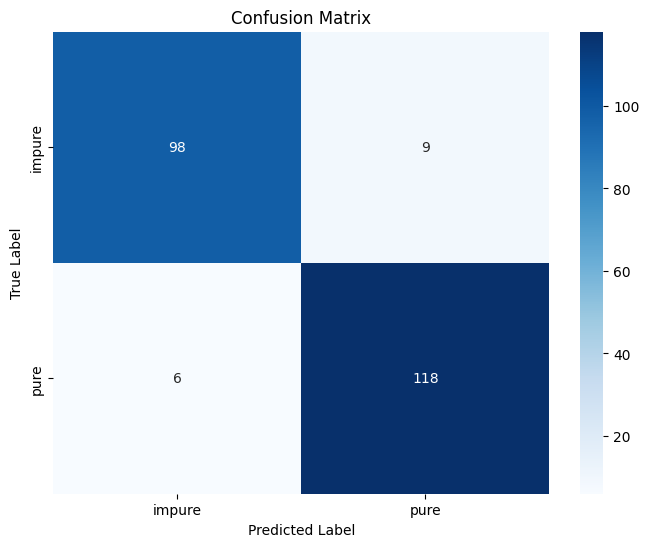

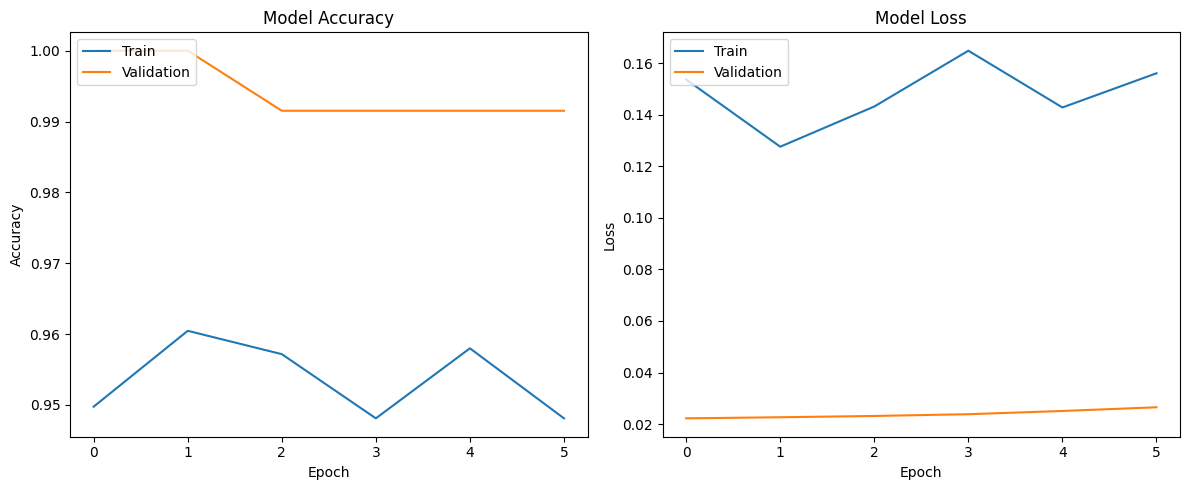

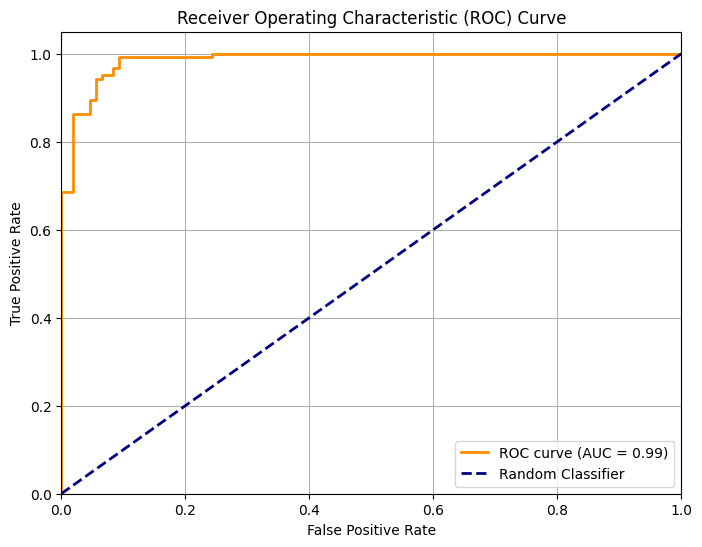

Area Under the Curve (AUC): 0.9864


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# 2. Get the true labels from the test_generator
true_labels = test_generator.classes

# 3. Obtain the raw predictions (probabilities) from the best_model on the test_generator
predictions_proba = best_model.predict(test_generator)

# 4. Convert the prediction probabilities to binary class labels using a threshold of 0.5
predicted_labels = np.round(predictions_proba)

# 5. Generate and print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['impure', 'pure']))

# 6. Generate a confusion matrix and visualize it
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['impure', 'pure'], yticklabels=['impure', 'pure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 7. Plot the training and validation accuracy and loss over epochs
# Check if history_scheduler_fine_tune is defined, otherwise use history_full_fine_tune as a fallback
# This assumes the last successful training history object contains the most relevant data.
if 'history_scheduler_fine_tune' in locals() and history_scheduler_fine_tune is not None:
    history_to_plot = history_scheduler_fine_tune
elif 'history_full_fine_tune' in locals() and history_full_fine_tune is not None:
    history_to_plot = history_full_fine_tune
elif 'history_fine_tune_top' in locals() and history_fine_tune_top is not None:
    history_to_plot = history_fine_tune_top
elif 'history_fine_tune' in locals() and history_fine_tune is not None:
    history_to_plot = history_fine_tune
elif 'history_transfer' in locals() and history_transfer is not None:
    history_to_plot = history_transfer
else:
    history_to_plot = history # Fallback to the initial CNN history if no fine-tuning history is available

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_to_plot.history['accuracy'])
plt.plot(history_to_plot.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_to_plot.history['loss'])
plt.plot(history_to_plot.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# 8. Calculate the False Positive Rate (fpr), True Positive Rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions_proba)

# 9. Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# 10. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Area Under the Curve (AUC): {roc_auc:.4f}")